In [1]:
import nasdaqdatalink as quandl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sharadar import equity_prices

In [2]:
quandl.ApiConfig.api_key = 'NRvcyMwNMXZ2ooDSM3nw'
universe = quandl.get_table('SHARADAR/SP500', action='historical', date='2022-12-31')
universe.head()

,date,action,ticker,name,contraticker,contraname,note
None,,,,,,,
0,2022-12-31,historical,ZTS,ZOETIS INC,N/A,N/A,None
1,2022-12-31,historical,ZION,ZIONS BANCORPORATION NATIONAL ASSOCIATION,N/A,N/A,None
2,2022-12-31,historical,ZBRA,ZEBRA TECHNOLOGIES CORP,N/A,N/A,None
3,2022-12-31,historical,ZBH,ZIMMER BIOMET HOLDINGS INC,N/A,N/A,None
4,2022-12-31,historical,YUM,YUM BRANDS INC,N/A,N/A,None


In [3]:
fundamentals = quandl.get_table('SHARADAR/SF1', datekey={'gte':'2022-07-31','lte':'2022-12-31'}, dimension="ART", ticker=",".join(universe['ticker'].to_list()))
fundamentals = fundamentals.drop_duplicates("ticker", keep="first")
fundamentals.head()

,ticker,dimension,calendardate,datekey,reportperiod,lastupdated,accoci,assets,assetsavg,assetsc,...,sharesbas,shareswa,shareswadil,sps,tangibles,taxassets,taxexp,taxliabilities,tbvps,workingcapital
None,,,,,,,,,,,,,,,,,,,,,
0,ZTS,ART,2022-09-30,2022-11-03,2022-09-30,2023-08-08,-809000000,13674000000,13801000000,6.551000e+09,...,466071995,467800000,469100000.0,17.116,9663000000,111000000,506000000.0,581000000,20.656,3.671000e+09
2,ZION,ART,2022-09-30,2022-11-03,2022-09-30,2023-08-07,-3140000000,88474000000,90146000000,NaN,...,149617754,149628000,149792000.0,19.502,87440000000,0,226000000.0,0,584.383,NaN
4,ZBRA,ART,2022-09-30,2022-11-01,2022-10-01,2023-08-01,-34000000,7448000000,6794250000,1.871000e+09,...,51629798,51629798,NaN,111.273,2898000000,315000000,77000000.0,96000000,56.130,-2.020000e+08
6,ZBH,ART,2022-09-30,2022-11-02,2022-09-30,2023-08-01,-244900000,21333300000,21964975000,4.534400e+09,...,209852392,209800000,210300000.0,34.093,7398000000,234600000,2100000.0,1153000000,35.262,2.238700e+09
8,YUM,ART,2022-09-30,2022-11-08,2022-09-30,2023-08-07,-298000000,5779000000,5837750000,1.595000e+09,...,281687866,281687866,NaN,23.831,4805000000,667000000,358000000.0,16000000,17.058,3.510000e+08


In [6]:
fundamentals.sort_values("datekey", inplace=True)
fundamentals["OneDRet"] = 0.0
fundamentals["FiveDRet"] = 0.0
fundamentals["TwentyOneDRet"] = 0.0
datekeys = fundamentals["datekey"].unique()
for d in datekeys:
    tickers = fundamentals[fundamentals["datekey"] == d]["ticker"].to_list()
    df = equity_prices.get_price_daterange(tickers, d)
    for t in tickers:
        tdf = df[df["ticker"] == t]
        if not tdf.empty:
            tdf = tdf.sort_values("date")
            fundamentals.loc[fundamentals["ticker"] == t, "OneDRet"] = tdf.iloc[1]["closeadj"] / tdf.iloc[0]["closeadj"] - 1
            fundamentals.loc[fundamentals["ticker"] == t, "FiveDRet"] = tdf.iloc[5]["closeadj"] / tdf.iloc[0]["closeadj"] - 1
            fundamentals.loc[fundamentals["ticker"] == t, "TwentyOneDRet"] = tdf.iloc[21]["closeadj"] / tdf.iloc[0]["closeadj"] - 1

In [7]:
df = pd.merge(left=universe, right=fundamentals, left_on="ticker", right_on="ticker", how="left")
df[df["datekey"].isna()]
# Sharadar only supports primary share query

,date,action,ticker,name,contraticker,contraname,note,dimension,calendardate,datekey,...,sps,tangibles,taxassets,taxexp,taxliabilities,tbvps,workingcapital,OneDRet,FiveDRet,TwentyOneDRet
98,2022-12-31,historical,SBNY,SIGNATURE BANK CORP,N/A,N/A,None,NaN,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160,2022-12-31,historical,NWS,NEWS CORP,N/A,N/A,None,NaN,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
296,2022-12-31,historical,GOOG,ALPHABET INC,N/A,N/A,None,NaN,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
310,2022-12-31,historical,FRCB,FIRST REPUBLIC BANK,N/A,N/A,None,NaN,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
312,2022-12-31,historical,FOX,FOX CORP,N/A,N/A,None,NaN,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
revenue = fundamentals.revenue
fundamentals["operating_margin"] = fundamentals.opinc / revenue.where(revenue > 0)
# exclude companies with negative operating expenses or negative cost of revenue
opex = fundamentals.opex
cor = fundamentals.cor
fundamentals["operating_margin"] = fundamentals["operating_margin"].where((opex > 0) & (cor > 0))
# clip range to (-1, 1) so as not to overweight outliers
fundamentals["operating_margin"] = fundamentals["operating_margin"].clip(-1, 1)
# The formula for the Fama-French profitability factor using Sharadar fields is: (REVENUE - COR - INTEXP - SGNA) / EQUITY.

In [9]:
fundamentals["operating_margin"].describe()

count    458.000000
mean       0.178646
std        0.151199
min       -0.853586
25%        0.097932
50%        0.166460
75%        0.253165
max        0.702333
Name: operating_margin, dtype: float64

In [10]:
negative_opermargin = fundamentals[fundamentals["operating_margin"] <= 0]["operating_margin"]
twenty_five_percentile = np.nanpercentile(negative_opermargin, 50)
first_quantile = negative_opermargin[negative_opermargin <= twenty_five_percentile]
second_quantile = negative_opermargin[negative_opermargin > twenty_five_percentile]

positive_opermargin = fundamentals[fundamentals["operating_margin"] > 0]["operating_margin"]
seventy_five_percentile = np.nanpercentile(positive_opermargin, 50)
third_quantile = positive_opermargin[positive_opermargin <= seventy_five_percentile]
forth_quantile = positive_opermargin[positive_opermargin > seventy_five_percentile]

In [11]:
days_count = 1
total_count = len(fundamentals["operating_margin"])
factor_quantile = {"Factor Quantile": ["1 (most negative)", "2", "3", "4 (most negative)"],
 "min": [min(first_quantile), min(second_quantile), min(third_quantile), min(forth_quantile)],
 "max": [max(first_quantile), max(second_quantile), max(third_quantile), max(forth_quantile)],
 "mean": [np.mean(first_quantile), np.mean(second_quantile), np.mean(third_quantile), np.mean(forth_quantile)],
 "std": [np.std(first_quantile), np.std(second_quantile), np.std(third_quantile), np.std(forth_quantile)],
 "count": [len(first_quantile), len(second_quantile), len(third_quantile), len(forth_quantile)],
 "avg daily count": [len(first_quantile) / days_count, len(second_quantile) / days_count, len(third_quantile) / days_count, len(forth_quantile) / days_count],
 "count %": [len(first_quantile) / total_count, len(second_quantile) / total_count, len(third_quantile) / total_count, len(forth_quantile) / total_count]}

In [12]:
factor_quantile_df = pd.DataFrame(factor_quantile)
factor_quantile_df.set_index("Factor Quantile", inplace=True)
pd.set_option('display.precision', 3)
factor_quantile_df

,min,max,mean,std,count,avg daily count,count %
Factor Quantile,,,,,,,
1 (most negative),-0.854,-0.120,-0.325,0.223,10,10.0,0.02
2,-0.118,-0.002,-0.038,0.042,10,10.0,0.02
3,0.002,0.172,0.103,0.045,219,219.0,0.44
4 (most negative),0.172,0.702,0.287,0.109,219,219.0,0.44


In [13]:
firstq_returns = fundamentals[fundamentals["operating_margin"] <= twenty_five_percentile][["OneDRet", "FiveDRet", "TwentyOneDRet"]].median()
secondq_returns = fundamentals[(fundamentals["operating_margin"] > twenty_five_percentile) & (fundamentals["operating_margin"] <= 0) ][["OneDRet", "FiveDRet", "TwentyOneDRet"]].median()
thirdq_returns = fundamentals[(fundamentals["operating_margin"] > 0) & (fundamentals["operating_margin"] <= seventy_five_percentile) ][["OneDRet", "FiveDRet", "TwentyOneDRet"]].median()
forthq_returns = fundamentals[(fundamentals["operating_margin"] > seventy_five_percentile) ][["OneDRet", "FiveDRet", "TwentyOneDRet"]].median()

In [39]:
one_day_returns = [firstq_returns[0], secondq_returns[0], thirdq_returns[0], forthq_returns[0]]
five_day_returns = [firstq_returns[1], secondq_returns[1], thirdq_returns[1], forthq_returns[1]]
twentyone_day_returns = [firstq_returns[2], secondq_returns[2], thirdq_returns[2], forthq_returns[2]]

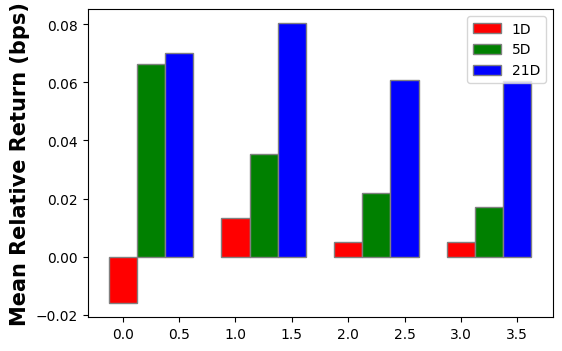

In [41]:
barWidth = 0.25
fig = plt.subplots(figsize =(6, 4))
br1 = np.arange(len(one_day_returns)) 
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
plt.bar(br1, one_day_returns, color ='r', width = barWidth, edgecolor ='grey', label ='1D') 
plt.bar(br2, five_day_returns, color ='g', width = barWidth, edgecolor ='grey', label ='5D') 
plt.bar(br3, twentyone_day_returns, color ='b', width = barWidth, edgecolor ='grey', label ='21D')
plt.ylabel('Mean Relative Return (bps)', fontweight ='bold', fontsize = 15) 
plt.legend()
plt.show()